<a href="https://colab.research.google.com/github/NazaGara/tm_seriesTV/blob/main/tw_shows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final - Text Mining 2021
Garagiola Nazareno


## Getting started

In [ ]:
!python -m spacy download es_core_news_md
!pip install --upgrade pandas
!pip install pyLDAvis
!pip install pysentimiento

Luego de ejecutar esta celda, hay que ir a Runtime -> Restart Runtime si estas en Google Colab. Si lo ejecutas via Jupyter, no hace falta hacerla, solo asegurate de haberlo instalado con los requerimientos.

In [1]:
import spacy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import random

random.seed(10)
np.random.seed(10)

In [2]:
from gensim.models import KeyedVectors

f = f"drive/MyDrive/tm_series/fasttext_spanish_twitter_100d.vec"

wordvectors = KeyedVectors.load_word2vec_format(f)

In [ ]:
with open('corpus.txt', 'r') as f:
    text = f.read()
    text = text.split('\n')
    corpus = list(set(text))
len(corpus)

19717

In [3]:
with open('stopwords.txt','r') as f:
    es_stop = f.read().split('\n')

In [4]:
import spacy
from pysentimiento import create_analyzer
nlp = spacy.load("es_core_news_md")
analyzer = create_analyzer(task='sentiment',lang="es")

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/925 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

## Procesamiento

In [ ]:
words = list()
for tw in corpus:
    for w in tw.split(' '):
        words.append(w.lower())

counter = Counter(words)

In [ ]:
import re
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def filter_token(token):
    """
    Funcion para filtrar los tokens que no son interesantes. No usa las stopwords.
    """
    return len(token.text) < 2 or token.is_punct or token.like_url or token.is_space or token.text[0]=='@'

def convert_listwords(list_words):
    """
    Funcion para pasar de una lista de palabras (ya procesadas preferentemente)
    a texto
    """
    text = ""
    for word in list_words:
        text = text + " " + word
    text = re.sub('['+ punctuation + ']+', ' ', text)
    text = re.sub('([0-9]+)', '', text)             
    return text

def clean_tweets(corpus=corpus):
    """
    Funcion para filtrar las palabras de los tweets luego de procesarlas con 
    Spacy y con pysentimento.
    Devuelve un diccionario que le asignan un unico ID a cada tweet.
    """
    data = {}
    wv_data = {}
    for position, tweet in enumerate(corpus):
        doc = nlp(tweet.strip())
        list_words = []
        vector_value = np.array([0 for i in range(100)], dtype=np.float64)
        sentiment = analyzer.predict(tweet)
        for token in doc:
            if filter_token(token): continue
            list_words.append(token.text.lower())
            if not (token.text.lower() in wordvectors.vocab): continue
            vector_value += np.array(wordvectors.word_vec(token.text.lower()), dtype=np.float64)
        
        data[position] = {"tweet": convert_listwords(list_words), "vector": '', "wv_vector": vector_value, "sentiment": sentiment.output}

    return data 

In [ ]:
data = clean_tweets(corpus)
tweets = [data[i]['tweet'] for i in data]
sents = [data[i]['sentiment'] for i in data]
wv_vectors = [data[i]['wv_vector'] for i in data]
wv_X = np.matrix(wv_vectors)

---

In [5]:
#Se puede directamente cargar si ya tenias hecho!
#Diccionario con los tweets y vectores
with open('drive/MyDrive/tm_series/data.pkl', 'rb') as f:
    data = pickle.load(f)

tweets = [data[i]['tweet'] for i in data]
sents = [data[i]['sentiment'] for i in data]
wv_vectors = [data[i]['wv_vector'] for i in data]
wv_X = np.matrix(wv_vectors)

#Dataset con tweets - coord tsne - tweet - cluster
with open('drive/MyDrive/tm_series/dataframe.pkl', 'rb') as handle:
    all_df = pickle.load(handle)
with open('drive/MyDrive/tm_series/wv_dataframe.pkl', 'rb') as handle:
    wv_df = pickle.load(handle)

#Diccionario con nombre de cluster, valores de palabras de PMI y de LDA
with open('drive/MyDrive/tm_series/pmi_lda.pkl', 'rb') as handle:
    pmi_lda = pickle.load(handle)
with open('drive/MyDrive/tm_series/wv_pmi_lda.pkl', 'rb') as handle:
    wv_pmi_lda = pickle.load(handle)


---
## Vectorización

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(array, min_df):
    vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=es_stop, min_df=min_df)
    matrix = vectorizer.fit_transform(array)
    return matrix

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-7
def transform(matrix):
    selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    normed_matrix = normalize(matrix, axis=1, norm='l1')
    reduced_matrix = selector.fit_transform(normed_matrix)
    return normed_matrix, reduced_matrix

In [ ]:
clean_X = vectorize(tweets, 80)
normed_X, transformed_X = transform(clean_X)
transformed_X.shape, wv_X.shape

---

In [ ]:
for pos, key in enumerate(list(data.keys())):
    data[key]['vector'] = transformed_X[pos]

In [ ]:
data_file = open("drive/MyDrive/tm_series/data.pkl", "wb")
pickle.dump(data, data_file)

---

In [ ]:
from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    """
    Se usa la euclidea porque ya estan normalizados, y cosine normalizada 
    es parecida a euclidea.
    Retorna los labels de cada punto y una lista con las coordenadas de los 
    centroides de cada cluster.
    """
    clusterer = KMeans(n_clusters=k, random_state=10, n_init=20)
    clusterer.fit(X=matrix)
    return clusterer.labels_, clusterer.cluster_centers_

from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    """
    Reduccion de dimensionalidad via T-sne para poder visualizar los datos
    """
    tsne = TSNE(n_components=2, random_state=10)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

---
## Visualizacion

In [ ]:
def setup_df(matrix, n_clusters):
    sk_cluster, centers =  sklearn_clustering(n_clusters, matrix)
    tsne_data = tsne_reduction(matrix)

    row = [(tsne_data[i], sk_cluster[i], tweets[i], sents[i]) for i in range(len(data))]
    df = pd.DataFrame(
        data=[(coords[0], coords[1], cluster, word, sent) for coords, cluster, word, sent in row],
        columns=["dim1", "dim2", "cluster", "tweet", "sentiment"]
    )
    return df    

In [ ]:
def plot_all(df, colorbar=False):
    plt.figure(figsize=(22, 8))
    g = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='tab20', alpha=1)
    if colorbar: plt.colorbar(g)
    plt.show()

def show_cluster(df, n):
    msgs = list(df[df['cluster']==n]['tweet'])
    for msg in msgs:
        text = msg
        print(text)

def df_of_cluster(df, n):
    return df[df['cluster']==n]

from random import randint

def show_sample(df, NUM_CLUSTERS=20):
    for i in range(NUM_CLUSTERS):
        u = randint(0,NUM_CLUSTERS)
        msg = list(df[df['cluster']==i]['tweet'])[u]
        print(f"Cluster {i}. Sample: {msg}")

In [ ]:
all_df = setup_df(transformed_X, 20)
wv_df = setup_df(wv_X, 20)

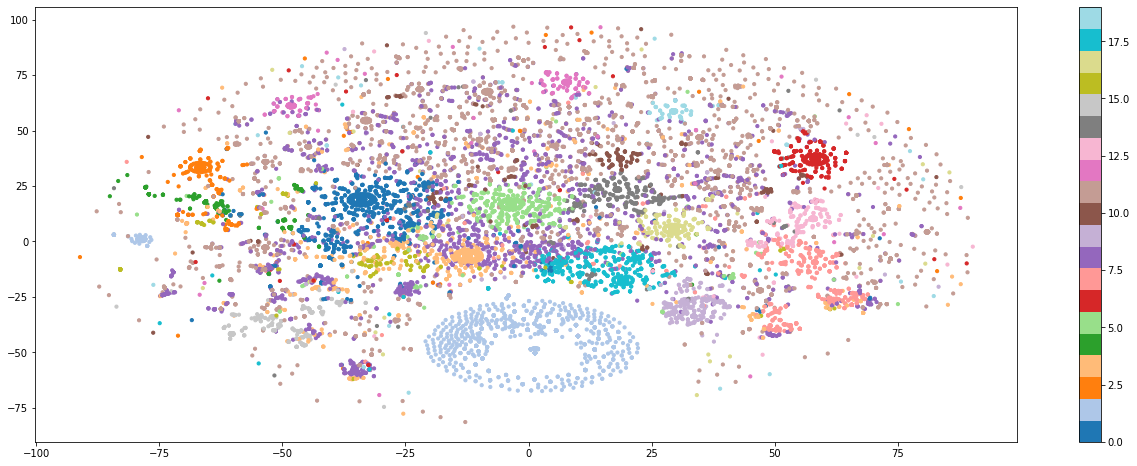

In [ ]:
plot_all(all_df, True)

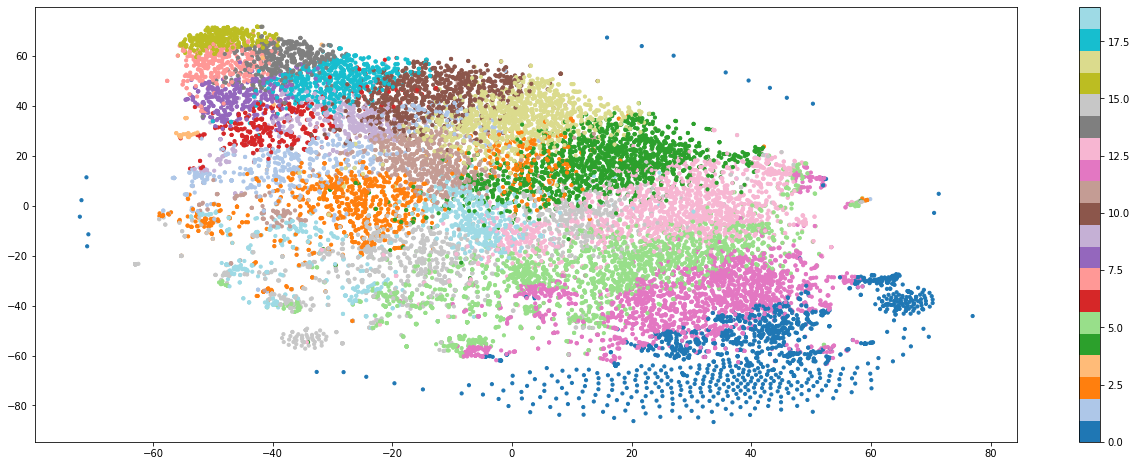

In [ ]:
plot_all(wv_df, True)

In [ ]:
# Guardamos los dataframe para no tener que volver a cargar todo de vuelta
all_df.to_pickle(f"drive/MyDrive/tm_series/dataframe.pkl")
wv_df.to_pickle(f"drive/MyDrive/tm_series/wv_dataframe.pkl")

In [ ]:
# Si ya tenemos toda esa parte procesada, podemos tomarlo directamente!
with open('drive/MyDrive/tm_series/dataframe.pkl', 'rb') as handle:
    all_df = pickle.load(handle)
with open('drive/MyDrive/tm_series/wv_dataframe.pkl', 'rb') as handle:
    wv_df = pickle.load(handle)

---
## PMI

In [6]:
def count_words(df):
    words = list()
    for tw in df['tweet'].tolist():
        for w in tw.split(' '):
            if w in es_stop or len(w) <= 2: continue
            words.append(w.lower())

    counter = Counter(words)
    return counter

def pmi_for_sentiment(counter, sent_counter, amount_of_sent_on_df):
    pmi = {}
    for w in sent_counter:
        pmi[w] = np.log2(sent_counter[w]/(counter[w] * amount_of_sent_on_df))
    return Counter(pmi)


def min_freq(counter, freq=5):
    copy = Counter(counter)
    for w in counter:
        if copy[w] <= freq: del copy[w]
    return copy

In [7]:
def sentiment_words(df, freq):
    """
    Funcion que a partir de un dataframe, te da las palabras mas relevantes para
    cada sentimiento, que cumplen una minima cantidad de veces, dada por el 
    parametro freq.
    """
    pos_df = df[df['sentiment'] == 'POS']
    neg_df = df[df['sentiment'] == 'NEG']
    neu_df = df[df['sentiment'] == 'NEU']

    #Cuento la frecuencia de cada palabra en el cluster
    counter_pos = count_words(pos_df)
    counter_neg = count_words(neg_df)
    counter_neu = count_words(neu_df)
    counter_all = count_words(df)

    #Aca desechamos todas aquellas palabras que aparezcan menos de MIN veces
    counter_pos = min_freq(counter_pos, freq=freq)
    counter_neg = min_freq(counter_neg, freq=freq)
    counter_neu = min_freq(counter_neu, freq=freq)
    counter_all = min_freq(counter_all, freq=freq)

    pos_pmi = pmi_for_sentiment(counter_all, counter_pos, len(pos_df))
    neg_pmi = pmi_for_sentiment(counter_all, counter_neg, len(neg_df))
    neu_pmi = pmi_for_sentiment(counter_all, counter_neu, len(neu_df))

    pos_words = [key for key, _ in pos_pmi.most_common(5)]
    neg_words = [key for key, _ in neg_pmi.most_common(5)]
    neu_words = [key for key, _ in neu_pmi.most_common(5)]

    return pos_words, neg_words, neu_words

---
## LDA

In [ ]:
import gensim 
import pyLDAvis.gensim_models

def LDA_topic_detect(tws_bow, N_TOPICS=7):
    """
    Implementacion de LDA hecha por gensim, lo retoque para que la funcion 
    retorne el modelo que se entrena, una forma de poder visualizarlo y la lista
    de los topicos mas relevantes.
    """
    dictionary = gensim.corpora.Dictionary(tws_bow)
    dictionary.filter_extremes(no_below=10, no_above=0.5)
    bow_corpus = [dictionary.doc2bow(doc) for doc in tws_bow]

    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = N_TOPICS,
                                   id2word = dictionary,                                    
                                   passes = 40,
                                   workers = 4)
    
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)

    topics = lda_model.show_topics(num_topics=N_TOPICS, num_words=5, formatted=False)
    topic_words = [(tp[0], [w[0] for w in tp[1]]) for tp in topics]
    topics_list = list()
    for _,words in topic_words:
        topics_list.append(words)

    return lda_model, vis, topics_list


---
## Extraccion de informacion

Las siguientes celdas, sirven para que podamos ver en funcionamiento las funciones detalladas mas arriba, con un ejemelo en concreto

In [ ]:
%%capture
# all: todo el dataset
nlp = spacy.load("es_core_news_md")
tw_list = all_df['tweet'].tolist()
tws_bow = list()
tweet_list = list()

for position, tweet in enumerate(tw_list):
    doc = nlp(tweet.strip())
    words = []
    for token in doc:
        if filter_token(token) or (token.text in es_stop): continue
        words.append(token.text)
    tweet_list.append(convert_listwords(words))
    tws_bow.append(words)

_, all_vis, all_topics_list = LDA_topic_detect(tws_bow, 7)
all_pos_words, all_neg_words, all_neu_words = sentiment_words(all_df, 20)

In [ ]:
all_neu_words, all_pos_words, all_neg_words

(['preocupaciones', 'licey', 'distrito', 'confirman', '10nov'],
 ['unirme', 'commerce', 'encanto', 'recomiendo', 'encanta'],
 ['derrumba', 'sobrevalorado', 'horrible', 'harta', 'cojones'])

In [ ]:
all_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.000307  0.278533       1        1  18.816913
4     -0.092461  0.042291       2        1  18.619833
2     -0.143731 -0.126349       3        1  13.987241
6     -0.135635 -0.057147       4        1  13.263332
0     -0.118289 -0.003566       5        1  11.994584
5      0.276288  0.101453       6        1  11.776750
1      0.214135 -0.235214       7        1  11.541346, topic_info=             Term         Freq        Total Category  logprob  loglift
46          serie  2106.000000  2106.000000  Default  30.0000  30.0000
127         ninos  1009.000000  1009.000000  Default  29.0000  29.0000
57        netflix   864.000000   864.000000  Default  28.0000  28.0000
180         visto   774.000000   774.000000  Default  27.0000  27.0000
187     temporada   621.000000   621.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
3            mama    67.898602    92.993436   Topic7  -5.0141   1.8447
99          video   105.180043   264.312920   Topic7  -4.5764   1.2378
124      jajajaja    63.161328    93.378277   Topic7  -5.0864   1.7683
114  criptomoneda    62.142408   446.569972   Topic7  -5.1027   0.1871
327     creadores    59.064933   178.941342   Topic7  -5.1535   1.0508

[391 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
790       2  0.711233        10
790       4  0.128022        10
790       6  0.163584        10
1118      6  0.971083        14
1278      7  0.983881        20
...     ...       ...       ...
55        2  0.968726       wtf
84        4  0.998550        xd
481       3  0.994555      york
1286      6  0.980548       you
801       1  0.979911  youtuber

[544 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 7, 1, 6, 2])

---

In [ ]:
def compute_pmi_and_lda(df, N_TOPICS, freq=5):
    """
    Funcion que a partir de un dataframe con los tweets, hace un procesamiento 
    de los datos obteniendo un bag of words y usando las funciones definidas 
    para LDA y para tomar las palabras mas significativas de cada sentimiento.
    """
    nlp = spacy.load("es_core_news_md")
    tw_list = df['tweet'].tolist()
    tws_bow = list()

    for position, tweet in enumerate(tw_list):
        doc = nlp(tweet.strip())
        words = []
        for token in doc:
            if filter_token(token) or (token.text in es_stop): continue
            words.append(token.text)
        tws_bow.append(words)

    _, _, topics_list = LDA_topic_detect(tws_bow, N_TOPICS)
    pos_words, neg_words, neu_words = sentiment_words(df, freq)
    return topics_list, pos_words, neg_words, neu_words

def display(topics_list, pos_words, neg_words, neu_words):
    for i,tp_list in enumerate(topics_list):
        print(f"Topicos {i}: {tp_list}")
    print(f"Palabras mas positivas: {pos_words}")
    print(f"Palabras mas negativas: {neg_words}")
    print(f"Palabras mas neutrales: {neu_words}")

In [ ]:
%%capture
pmi_lda = {"dataset": compute_pmi_and_lda(all_df, N_TOPICS=7, freq=20)}
for i in range(0, 20): 
    pmi_lda[f"{i}"] = compute_pmi_and_lda(df=df_of_cluster(all_df,i), N_TOPICS=7)

In [ ]:
%%capture
wv_pmi_lda = {"dataset": compute_pmi_and_lda(wv_df, N_TOPICS=7, freq=20)}
for i in range(0, 20):
    wv_pmi_lda[f"{i}"] = compute_pmi_and_lda(df=df_of_cluster(wv_df,i), N_TOPICS=7)

---

In [ ]:
pmi_lda_file = open("drive/MyDrive/tm_series/pmi_lda.pkl", "wb")
pickle.dump(pmi_lda, pmi_lda_file)

In [ ]:
wv_pmi_lda_file = open("drive/MyDrive/tm_series/wv_pmi_lda.pkl", "wb")
pickle.dump(wv_pmi_lda, wv_pmi_lda_file)

In [ ]:
# Si ya tenemos toda esa parte procesada, podemos tomarlo directamente!
with open('drive/MyDrive/tm_series/pmi_lda.pkl', 'rb') as handle:
    pmi_lda = pickle.load(handle)
with open('drive/MyDrive/tm_series/wv_pmi_lda.pkl', 'rb') as handle:
    wv_pmi_lda = pickle.load(handle)

---

In [ ]:
for k in pmi_lda:
    print(f"-----{k}-----")
    display(pmi_lda[k][0],pmi_lda[k][1],pmi_lda[k][2],pmi_lda[k][3])

In [ ]:
for k in wv_pmi_lda:
    print(f"-----{k}-----")
    display(wv_pmi_lda[k][0],wv_pmi_lda[k][1],wv_pmi_lda[k][2],wv_pmi_lda[k][3])

---

## Clasificación

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import accuracy_score, recall_score, classification_report

In [9]:
def count_subwords(s, w):
    return f' {s} '.count(f' {w} ')

def df_of_cluster(df, n):
    return df[df['cluster']==n]

def identify_topic(tweet, topic_list):
    """
    Funcion que la uso para poder identificar sobre que topicos habla un tweet,
    A partir de una lista de topicos (dadas por cada Cluster) identifica los que
    mas aparezcan en el tweet. 
    Notar que si en ningun de los casos matchea, da los topicos del 0-esimo 
    cluster.
    """
    counts = [0 for _ in range(len(topic_list))]
    for i in range(len(topic_list)):
        c = 0
        for t in topic_list[i]:
            c += count_subwords(tweet, t)
        counts[i] = c
    
    y = counts.index(max(counts))

    return y

def identify_sentiment(tweet_list, sentiments_list):
    """
    Con la funcion podemos a partir de la lista de tweets, en base a las 
    palabras que lo compenen, identificar su sentimiento, lo cual es mas rapido
    que reutilizar la libreria de sentimiento.
    """
    y = np.empty(0)
    labels = {0: 'NEU', 1: 'POS', 2: 'NEG'}
    for tw in tweet_list:
        counts = [0 for _ in range(len(sentiments_list))]
        for i in range(len(sentiments_list)):
            c = 0
            for w in sentiments_list[i]:
                c += count_subwords(tw, w)
            counts[i] = c
        y = np.append(y, labels[counts.index(max(counts))])
    return y

In [161]:
def evaluate(df, K, pmi_lda, vector_type, classifier=LogisticRegression):
    indexes = df.index
    _, pos, neg, neu = pmi_lda[f'{K}']
    adds_idxs = [1,2,4]

    # Get data
    if vector_type == "wv_vector" : 
        X = np.array([data[i][vector_type] for i in indexes])
        addons = np.array([data[j][vector_type] for j in adds_idxs])
    elif vector_type == "vector": 
        X = np.array([data[i][vector_type].toarray()[0] for i in indexes])
        addons = np.array([data[j][vector_type].toarray()[0] for j in adds_idxs])
    else: print("Not supported type of vector. Try again")

    # Get tags for the data
    tweets = [data[i]['tweet'] for i in indexes]
    adds_tweets = [data[i]['tweet'] for i in adds_idxs]
    adds_sents = ['POS', 'NEG', 'NEU'] #identify_sentiment(adds_tweets, [neu, pos, neg])
    y = identify_sentiment(tweets, [neu, pos, neg]) # df['sentiment'].tolist()
    
    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
    X_train = np.concatenate((X_train, addons), axis=0)
    y_train = np.concatenate((y_train, adds_sents), axis=0)
    # Classifier
    clf = classifier(random_state=10, solver='newton-cg')
    clf.fit(X_train, y_train)

    # make predictions
    y_pred = clf.predict(X_test)

    #evaluate
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    return clf, report 

In [152]:
predictors = {'dataset': evaluate(all_df, K='dataset', pmi_lda=pmi_lda, vector_type='vector')} #, classifier=GradientBoostingClassifier)}
for j in range(20):
    predictors[j] = evaluate(df_of_cluster(all_df, j), K=j, pmi_lda=pmi_lda, vector_type='vector')

wv_predictors = {'dataset': evaluate(wv_df, K='dataset', pmi_lda=wv_pmi_lda, vector_type='wv_vector')} #, classifier=GradientBoostingClassifier)}
for j in range(20):
    wv_predictors[j] = evaluate(df_of_cluster(wv_df, j), K=j, pmi_lda=wv_pmi_lda, vector_type='wv_vector')


In [162]:
print('Con Count-Vectorizer')
for k in predictors:
    print(f"Df {k}. Report: \n{predictors[k][1]} ") #--- Recall [NEU,POS,NEG]: {predictors[k][2]}")

print('\nCon Embeddings')
for k in wv_predictors:
    print(f"Df {k}. Report: \n{wv_predictors[k][1]} ") #--- Recall [NEU,POS,NEG]: {wv_predictors[k][2]}")

Con Count-Vectorizer
Df dataset. Report: 
{'NEG': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 48}, 'NEU': {'precision': 0.9858613800522514, 'recall': 1.0, 'f1-score': 0.9928803590775422, 'support': 6415}, 'POS': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 44}, 'accuracy': 0.9858613800522514, 'macro avg': {'precision': 0.3286204600174171, 'recall': 0.3333333333333333, 'f1-score': 0.3309601196925141, 'support': 6507}, 'weighted avg': {'precision': 0.9719226606785298, 'recall': 0.9858613800522514, 'f1-score': 0.9788424010269607, 'support': 6507}} 
Df 0. Report: 
{'NEG': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, 'NEU': {'precision': 0.8801089918256131, 'recall': 1.0, 'f1-score': 0.936231884057971, 'support': 323}, 'POS': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 32}, 'accuracy': 0.8801089918256131, 'macro avg': {'precision': 0.29336966394187103, 'recall': 0.3333333333333333, 'f1-score': 0.3120772946859903, 'su

## Predicciones

In [ ]:
%%capture
from pysentimiento import create_analyzer
analyzer = create_analyzer(task='sentiment',lang="es")
import spacy
nlp = spacy.load("es_core_news_md")
import re
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

In [147]:
def filter_token(token):
    """
    Funcion para filtrar los tokens que no son interesantes. No usa las stopwords.
    """
    return len(token.text) < 2 or token.is_punct or token.like_url or token.is_space or token.text[0]=='@'

def convert_listwords(list_words):
    """
    Funcion para pasar de una lista de palabras (ya procesadas preferentemente)
    a texto
    """
    text = ""
    for word in list_words:
        text = text + " " + word
    text = re.sub('['+ punctuation + ']+', ' ', text)
    text = re.sub('([0-9]+)', '', text)             
    return text

In [148]:
topics_list = []
for k in wv_pmi_lda: 
    if k!='dataset': topics_list.append(wv_pmi_lda[k][0])
    
def get_cluster(tweet):
    topic_values = []

    for t in topics_list:
        topic_values.append(int(identify_topic(tweet, t)))

    if topic_values == [0 for _ in range(len(topics_list))]: #basicamente, que no ocurrio ninguna vez en la lista de topicos
        cluster, topics = "dataset", "Using dataset configuration, we dont have the topics related"
    else:
        cluster = topic_values.index(max(topic_values))
        topics = topics_list[cluster][max(topic_values)]

    return cluster, topics

def predict(tweets, preds):
    topics, cluster_pred, dataset_pred = [], [], []
    pysent = []
    clf_dataset = preds['dataset'][0]
    for tw in tweets:
        sentiment = analyzer.predict(tw)
        doc = nlp(tw)
        tw_vector, list_words = 0, []
        for token in doc:
            if filter_token(token) or token.text.lower() not in wordvectors.vocab or token.text in es_stop: continue
            tw_vector += np.array(wordvectors.word_vec(token.text.lower()), dtype=np.float64)
            list_words.append(token.text.lower())

        processed_tw = convert_listwords(list_words).strip()
        cluster, topic = get_cluster(processed_tw)
        clf_cluster = preds[cluster][0]

        topics.append(topic)
        cluster_pred.append(clf_cluster.predict([tw_vector]))
        dataset_pred.append(clf_dataset.predict([tw_vector]))
        pysent.append(sentiment.output)
    
    return cluster_pred, dataset_pred, topics, pysent

In [149]:
with open('evaluation_tweets.txt', 'r') as f:
    text = f.read()
    text = text.split('\n')
    eval_tweets = list(set(text))
len(eval_tweets)
eval_tweets.remove('')

In [168]:
%%capture
c_pred, d_pred, tpcs, pysent = predict(eval_tweets, wv_predictors)
score_general, score_clusters, values = 0, 0, []
for i in range(len(eval_tweets)):
    score_general += (d_pred[i][0] == pysent[i])
    score_clusters += (c_pred[i][0] == pysent[i])
    values.append(f"{eval_tweets[i]} - SENT: {c_pred[i][0], d_pred[i][0], pysent[i]} - TOPICS: {tpcs[i]}")

In [166]:
score_general/len(eval_tweets), score_clusters/len(eval_tweets)

(0.5524193548387096, 0.4949596774193548)

In [169]:
values

["#FelizLunes Referencias a la #arquitectura arabe y griega se hacen presente en sus pasillos y patios. #LaMurallaRoja se ha convertido en inspiracion para los arquitectos y disenadores, e incluso El Juego del Calamar hace referencia a su arquitectura:   https://t.co/j1evtB8eny - SENT: ('POS', 'POS', 'POS') - TOPICS: Using dataset configuration, we dont have the topics related",
 "“El juego del calamar”: Jung HoYeon toma las redes de Calvin Klein y publica fotos suyas en ropa interior https://t.co/NkK2VhMETo - SENT: ('NEG', 'NEU', 'NEU') - TOPICS: ['disfraces', 'halloween', 'asi', 'visto', 'fotos']",
 "Estos dias estoy viviendo un verdadero juego del calamar (sin morision claro), yo ya considero que vivo en una distopia happy. - SENT: ('NEU', 'NEU', 'NEU') - TOPICS: ['ninos', 'halloween', 'dias', 'verde', 'personas']",
 "el famoso juego del calamar https://t.co/cHFnJ8WP46 - SENT: ('NEU', 'NEU', 'NEU') - TOPICS: Using dataset configuration, we dont have the topics related",
 "¿Todavia s